*(to use GPU in colab go to Runtime -> Change Runtime Type and change the hardware accelerator)*

# VAE with Discrete Variables For Semi-Supervised Learning

This practical session is inspired by ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf). We will also use this model to illustrate the Gumbel-Softmax trick.

In [4]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pylab as plt

from torch.distributions import Normal, Bernoulli, Independent

torch.manual_seed(0)
np.random.seed(0)

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('Using torch version {}'.format(torch.__version__))
print('Using {} device'.format(device))

Using torch version 1.1.0.post2
Using cpu device


For the semi-supervised learning task we remove 95% of labels from the training set. In the modified training set the observed labels have a standard one-hot encoding and the unobserved labels are represented by all-zero ten dimensional vectors.

In [5]:
data = MNIST(root='../../../data/', download=True, train=True)
new_train_labels = torch.zeros(60000, 10)
observed = np.random.choice(60000, 3000)
new_train_labels[observed] = torch.eye(10)[data.targets][observed]
train_data = TensorDataset(data.data.view(-1, 28 * 28).float() / 255,
                           new_train_labels)

data = MNIST(root='../../../data/', download=True, train=False)
test_data = TensorDataset(data.data.view(-1, 28 * 28).float() / 255,
                          data.targets)

## The probabilistic model

In the semi-supervised setting, the generative model is a little more complicated. In particular, it incorporates a new variable $y$ that represents the digits class.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

Typically, whenever we train a model with partial observations, we interpret unobserved variables as latent variables and marginalize over them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

### ELBO for observed variables

Similiar to VAE:

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

### ELBO for unobserved variables

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

### The final objective

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

Again, we will use reparametrized Monte-Carlo estimates to approximate expectation over $z$. To approximate expectaion over discrete variables $y$ we will use Gumbel-Softmax trick.

## Important practical aspect

ELBO maximization does not lead to any semantics in latent variables $y$. 

We are going to restrict variational approximations $q(y \mid x)$ to the ones that correctly classify observation $x$ on fully-observed variables $(x_i, y_i)$. As in the original paper, we will add a cross-entropy regularizer to the objective with weight $\alpha$:

\begin{equation}
\frac{1}{|P|}\sum_{i \in P} y_i^T \log q(y \mid x).
\end{equation}

## RelaxedOneHotCategorical

In the probabilistic model defined above we are going to replace categorical prior $p(y)$ and categorical variational approximation $q(y | x)$ with Gumbel-Softmax distribution. The distribution class is implemented in **torch.distributions.relaxed_categorical.RelaxedOneHotCategorical**.

For more details see [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144).

### An illustration for Gumbel-Softmax

- Temperature allows for smooth interpolation between one-hot categorical distribution with low temperature and a $(1/K, \dots, 1/K)$ vector with high temperatures
- The exact computation of $\mathbb E_{q(y|x)} f(y)$ requires computation of $f(y)$ for ten possible labels $y=0, \dots, 9$. On the other hand, with Gumbel-Softmax relaxation only one sample $y \sim q(y | x)$ is enough. Therefore, Gumbel-Softmax gives almost a ten-fold training speed increase.

Probs:  [0.6401817  0.10224042 0.01551747 0.24206041]


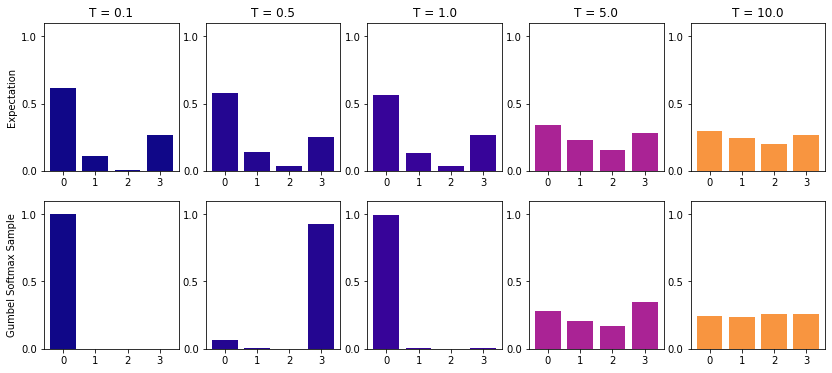

In [11]:
import matplotlib.cm as cm
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical

n_classes = 4
logits = torch.randn(1, n_classes)
print('Probs: ', torch.nn.functional.softmax(logits, 1).squeeze().numpy())
temperatures = [0.1, 0.5, 1., 5., 10.]
M = 128 # number of samples used to approximate distribution mean

fig, axes = plt.subplots(nrows=2, ncols=len(temperatures), figsize=(14, 6),
                         subplot_kw={'xticks': range(n_classes),
                                     'yticks': [0., 0.5, 1.]})
axes[0, 0].set_ylabel('Expectation')
axes[1, 0].set_ylabel('Gumbel Softmax Sample')

for n, t in enumerate(temperatures):
    dist = RelaxedOneHotCategorical(t, logits=logits)
    mean = torch.zeros_like(logits)
    for _ in range(M):
        mean += dist.sample() / M
    sample = dist.sample()
    
    axes[0, n].set_title('T = {}'.format(t))
    axes[0, n].set_ylim((0, 1.1))
    axes[1, n].set_ylim((0, 1.1))
    axes[0, n].bar(np.arange(n_classes), mean.numpy().reshape(n_classes),
                   color=cm.plasma(0.75 * t / max(temperatures)))
    axes[1, n].bar(np.arange(n_classes), sample.numpy().reshape(n_classes),
                   color=cm.plasma(0.75 * t / max(temperatures)))

# SS-VAE implementation

The computational graph for observed labels has the following structure:

![computational graph ss vae xy](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ss_vae_xy.png?raw=true)

The computational graph for unobserved lables has the following structure:

![computational graph ss vae xy](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ss_vae_x.png?raw=true)

In [12]:
n_classes, d, nh, D = 10, 32, 500, 28 * 28
default_T = torch.tensor(0.6, device=device)

yz_dec = nn.Sequential(
    nn.Linear(n_classes + d, nh),
    nn.ReLU(),
    nn.Linear(nh, D))

y_enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, n_classes))

z_enc = nn.Sequential(
    nn.Linear(n_classes + D, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)
    )

yz_dec = yz_dec.to(device)
y_enc = y_enc.to(device)
z_enc = z_enc.to(device)

# The task

Implement the loss function for the semi-supervised variational autoencoder

In [31]:
def loss(x, y, y_encoder, z_encoder, decoder, T=default_T, alpha=32.):#, verbose=False):
    #TODO
    """
    NOTE:                                                                        
      hyperparameter alpha was tuned for the implementation that computed
      the mean of elbo terms and sum of cross-entropy terms over the observed
      datapoints in the batch  
                                                                                 
      In the modified training set the observed labels have a standard one-hot     
      encoding and the unobserved labels are represented by all-zero ten           
      dimensional vectors.                                                         
      To compute the mask for observed labels you can compute                      
      y_is_observed = y.sum(1, keepdim=True)                                       
    
    The function has to
    1. sample y from q(y | x)
    2. sample z from q(z | x, y)
    3. compute the evidence lower bound for obervsed and unobserved variables
    4. compute the cross_entropy regularizer with weight alpha for object with
      observed labels
    5. return the sum of two losses
    """
    #y_is_observed = y.mean(1, keepdim=True)
    y_is_obsereved = y.mean()
    
    # Sample y from q(y|x)
    qy_x = RelaxedOneHotCategorical(T, logits=y_encoder(x))
    y_gumbel = qy_x.rsample()
    y_to_decode = y_gumbel * (1 * y_is_obsereved) + y * y_is_obsereved
    
    # Sample z from q(z | x, y)
    qz_xy_loc_scale = z_encoder(torch.cat((x, y_to_decode), 1))
    qz_xy = Independent(
        Normal(
            loc=qz_xy_loc_scale[:, :d],
            scale=torch.exp(qz_xy_loc_scale[:, d:])
        ),
        reinterpreted_batch_ndims=1
    )
    # This is the actual sample step
    z = qz_xy.rsample()
    
    # Compute ELBO for observed and unobserved variables
    py = RelaxedOneHotCategorical(T, logits=torch.zeros_like(y_gumbel))
    
    pz = Independent(
        Normal(
            loc=torch.zeros_like(z),
            scale=torch.zeros_like(z)
        ),
        reinterpreted_batch_ndims=1
    )
    
    px_yz_logits = decoder(torch.cat((y_to_decode, z)), 1)
    
    #return loss + alpha * loss_supervised

In [32]:
from itertools import chain

def train_model(y_encoder, z_encoder, decoder, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = optim.Adam(chain(y_encoder.parameters(),
                          z_encoder.parameters(),
                          decoder.parameters()), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    for _ in range(num_epochs):
        for i, (x, y) in enumerate(dataloader):
            total = len(dataloader)
            x = x.to(device)
            y = y.to(device)
            loss_value = loss(x, y, y_encoder, z_encoder, decoder)
            (-loss_value).backward()
            train_losses.append(loss_value.cpu().item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
            gd.zero_grad()
        loss_value = 0.
        accuracy = 0.
        for i, (x, y) in enumerate(test_dataloader):
            total = len(test_dataloader)
            x = x.to(device)
            y = y.to(device)
            unobserved_y = torch.zeros((y.shape[0], 10)).to(device)
            loss_value += loss(x, unobserved_y, y_encoder, z_encoder, decoder).item()
            accuracy += (torch.argmax(y_encoder(x), 1) == y).double().mean().item()
        print('Test loss: {}\t Test accuracy: {}'.format(loss_value / total, accuracy / total))

In [33]:
# my implementation omitted log p(y) for observed variables. it has
# test loss -106.79
# test accuracy 0.95
train_model(y_enc, z_enc, yz_dec, num_epochs=16)

--Return--
> <ipython-input-31-eba327992f16>(41)loss()->None
-> pdb.set_trace()
(Pdb) qz_xy
Independent()
(Pdb) qz_xy.rsample()
tensor([[ 1.6884, -0.1122,  0.9574,  ..., -0.3798,  0.8895,  0.6322],
        [-0.5565, -1.4361, -0.1091,  ...,  0.1427, -0.8264,  1.2539],
        [ 1.0830, -0.3343,  0.4047,  ..., -1.4848,  0.1339,  0.1398],
        ...,
        [-1.1188, -0.5711, -0.2566,  ..., -0.1247, -0.6234,  1.3689],
        [ 0.3865,  0.6443,  0.3770,  ..., -0.8156, -0.1758, -0.8635],
        [ 1.9266, -1.5798, -1.0758,  ...,  1.0651, -1.1156,  1.8949]],
       grad_fn=<AddBackward0>)
(Pdb) exit


BdbQuit: 

## Visualizations

Generate 10 images for each label

In [0]:
def plot_samples_with_fixed_classes(dec):
    decoder_input = torch.cat((torch.eye(10).repeat(10, 1), torch.randn(100, d)), 1)
    decoder_input = decoder_input.to(device)
    images = torch.sigmoid(dec(decoder_input)).view(100, 28, 28).detach().cpu().numpy()
    
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(14, 14),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(10):
        axes[0, i].set_title('{}'.format(i))
    
    for i in range(100):
        axes[int(i / 10), i % 10].imshow(images[i], cmap='gray')
        
plot_samples_with_fixed_classes(yz_dec)

### "Style-transfer"

Here we infer latent representation $z$ of a given digit $x$ and then generate from $p(x | z, y)$ for different $y$.

In [0]:
def plot_all_digits_with_fixed_style(z_enc, y_enc, dec):
    indices = np.random.choice(10000, 10)
    x, y = test_data[indices][0], torch.eye(10)[test_data[indices][1]]
    x = x.to(device)
    y = y.to(device)
    z = z_enc(torch.cat((x, y), 1))[:, :d]

    # generate digits
    images = []
    for i in range(10):
        digit_encodings = torch.eye(10)[i, :].expand(10, 10).to(device)
        images.append(torch.sigmoid(dec(torch.cat((digit_encodings, z), 1)).view(10, 28, 28)).detach().cpu().numpy())
        
    x = x.view(10, 28, 28).detach().cpu().numpy()

    # plot
    fig, axes = plt.subplots(nrows=10, ncols=11, figsize=(14, 14),
                             subplot_kw={'xticks': [], 'yticks': []})
    
    axes[0, 0].set_title('example')
    for i in range(10):
        axes[0, i + 1].set_title('{}'.format(i))
        axes[i, 0].imshow(x[i], cmap='gray')
        for j in range(10):
            axes[i, j + 1].imshow(images[j][i], cmap='gray')
            
plot_all_digits_with_fixed_style(z_enc, y_enc, yz_dec)

### T-SNE for SS-VAE

Do you notice any difference from T-SNE for vanilla VAE? How can you interpret the results?

In [0]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

In [0]:
# T-SNE for q(z | x, y) mean
labels = test_data[:1000][1].numpy()
encoder_input = torch.cat((test_data[:1000][0],
                           torch.eye(10)[labels]), 1).to(device)
latent_variables = z_enc(encoder_input)[:, :d]
latent_variables = latent_variables.detach().cpu().numpy()

plot_tsne(latent_variables, labels)

In [0]:
# T-SNE for q(y | x) logits
labels = test_data[:1000][1].numpy()
latent_variables = y_enc(test_data[:1000][0].to(device))
latent_variables = latent_variables.detach().cpu().numpy()

plot_tsne(latent_variables, labels)